In [1]:
import ensaio
import pandas as pd

fname = ensaio.fetch_southern_africa_gravity(version=1)
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


In [2]:
import numpy as np
import verde as vd

blocked_mean = vd.BlockReduce(np.mean, spacing=6 / 60, drop_coords=False)
(longitude, latitude, height), gravity_data = blocked_mean.filter(
    (data.longitude, data.latitude, data.height_sea_level_m),
    data.gravity_mgal,
)

data = pd.DataFrame(
    {
        "longitude": longitude,
        "latitude": latitude,
        "height_sea_level_m": height,
        "gravity_mgal": gravity_data,
    }
)
data

/home/runner/miniconda3/envs/test/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function mean at 0x7f927cfcd300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/runner/miniconda3/envs/test/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function mean at 0x7f927cfcd300> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


,longitude,latitude,height_sea_level_m,gravity_mgal
0,19.394500,-34.919505,0.00,979750.15
1,19.465000,-34.953000,0.00,979751.50
2,19.554000,-34.996000,0.00,979750.20
3,19.748000,-34.979000,0.00,979747.00
4,19.299585,-34.832660,0.00,979726.95
...,...,...,...,...
8072,15.896660,-17.395000,1104.30,978169.29
8073,15.973330,-17.390000,1106.40,978170.99
8074,16.068330,-17.390000,1110.25,978168.94
8075,16.140000,-17.390000,1112.50,978168.79


In [3]:
import boule as bl

ellipsoid = bl.WGS84
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height_sea_level_m)
gravity_disturbance = data.gravity_mgal - normal_gravity

In [4]:
import harmonica as hm

eqs = hm.EquivalentSourcesSph(damping=1e-3, relative_depth=10000)

In [5]:
coordinates = ellipsoid.geodetic_to_spherical(
    data.longitude, data.latitude, data.height_sea_level_m
)

In [6]:
eqs.fit(coordinates, gravity_disturbance)

EquivalentSourcesSph(damping=0.001, relative_depth=10000)

In [7]:
# Get the bounding region of the data in geodetic coordinates
region = vd.get_region((data.longitude, data.latitude))

# Get the maximum height of the data coordinates
max_height = data.height_sea_level_m.max()

# Define a regular grid of points in geodetic coordinates
grid_coords = vd.grid_coordinates(
    region=region, spacing=6 / 60, extra_coords=max_height
)

In [8]:
grid_coords_sph = ellipsoid.geodetic_to_spherical(*grid_coords)

In [9]:
gridded_disturbance = eqs.predict(grid_coords_sph)

In [10]:
grid = vd.make_xarray_grid(
    grid_coords,
    gridded_disturbance,
    data_names=["gravity_disturbance"],
    extra_coords_names="upward",
)
grid

<xarray.Dataset> Size: 595kB
Dimensions:              (northing: 177, easting: 209)
Coordinates:
  * easting              (easting) float64 2kB 11.91 12.01 12.11 ... 32.65 32.75
  * northing             (northing) float64 1kB -35.0 -34.9 ... -17.49 -17.39
    upward               (northing, easting) float64 296kB 2.622e+03 ... 2.62...
Data variables:
    gravity_disturbance  (northing, easting) float64 296kB 5.957 5.986 ... 3.892

In [11]:
grid = vd.distance_mask(
    data_coordinates=(data.longitude, data.latitude), maxdist=0.5, grid=grid
)

In [12]:
 import pygmt

 # Needed so that displaying works on jupyter-sphinx and sphinx-gallery at
 # the same time. Using PYGMT_USE_EXTERNAL_DISPLAY="false" in the Makefile
 # for sphinx-gallery to work means that fig.show won't display anything here
 # either.
 pygmt.set_display(method="notebook")

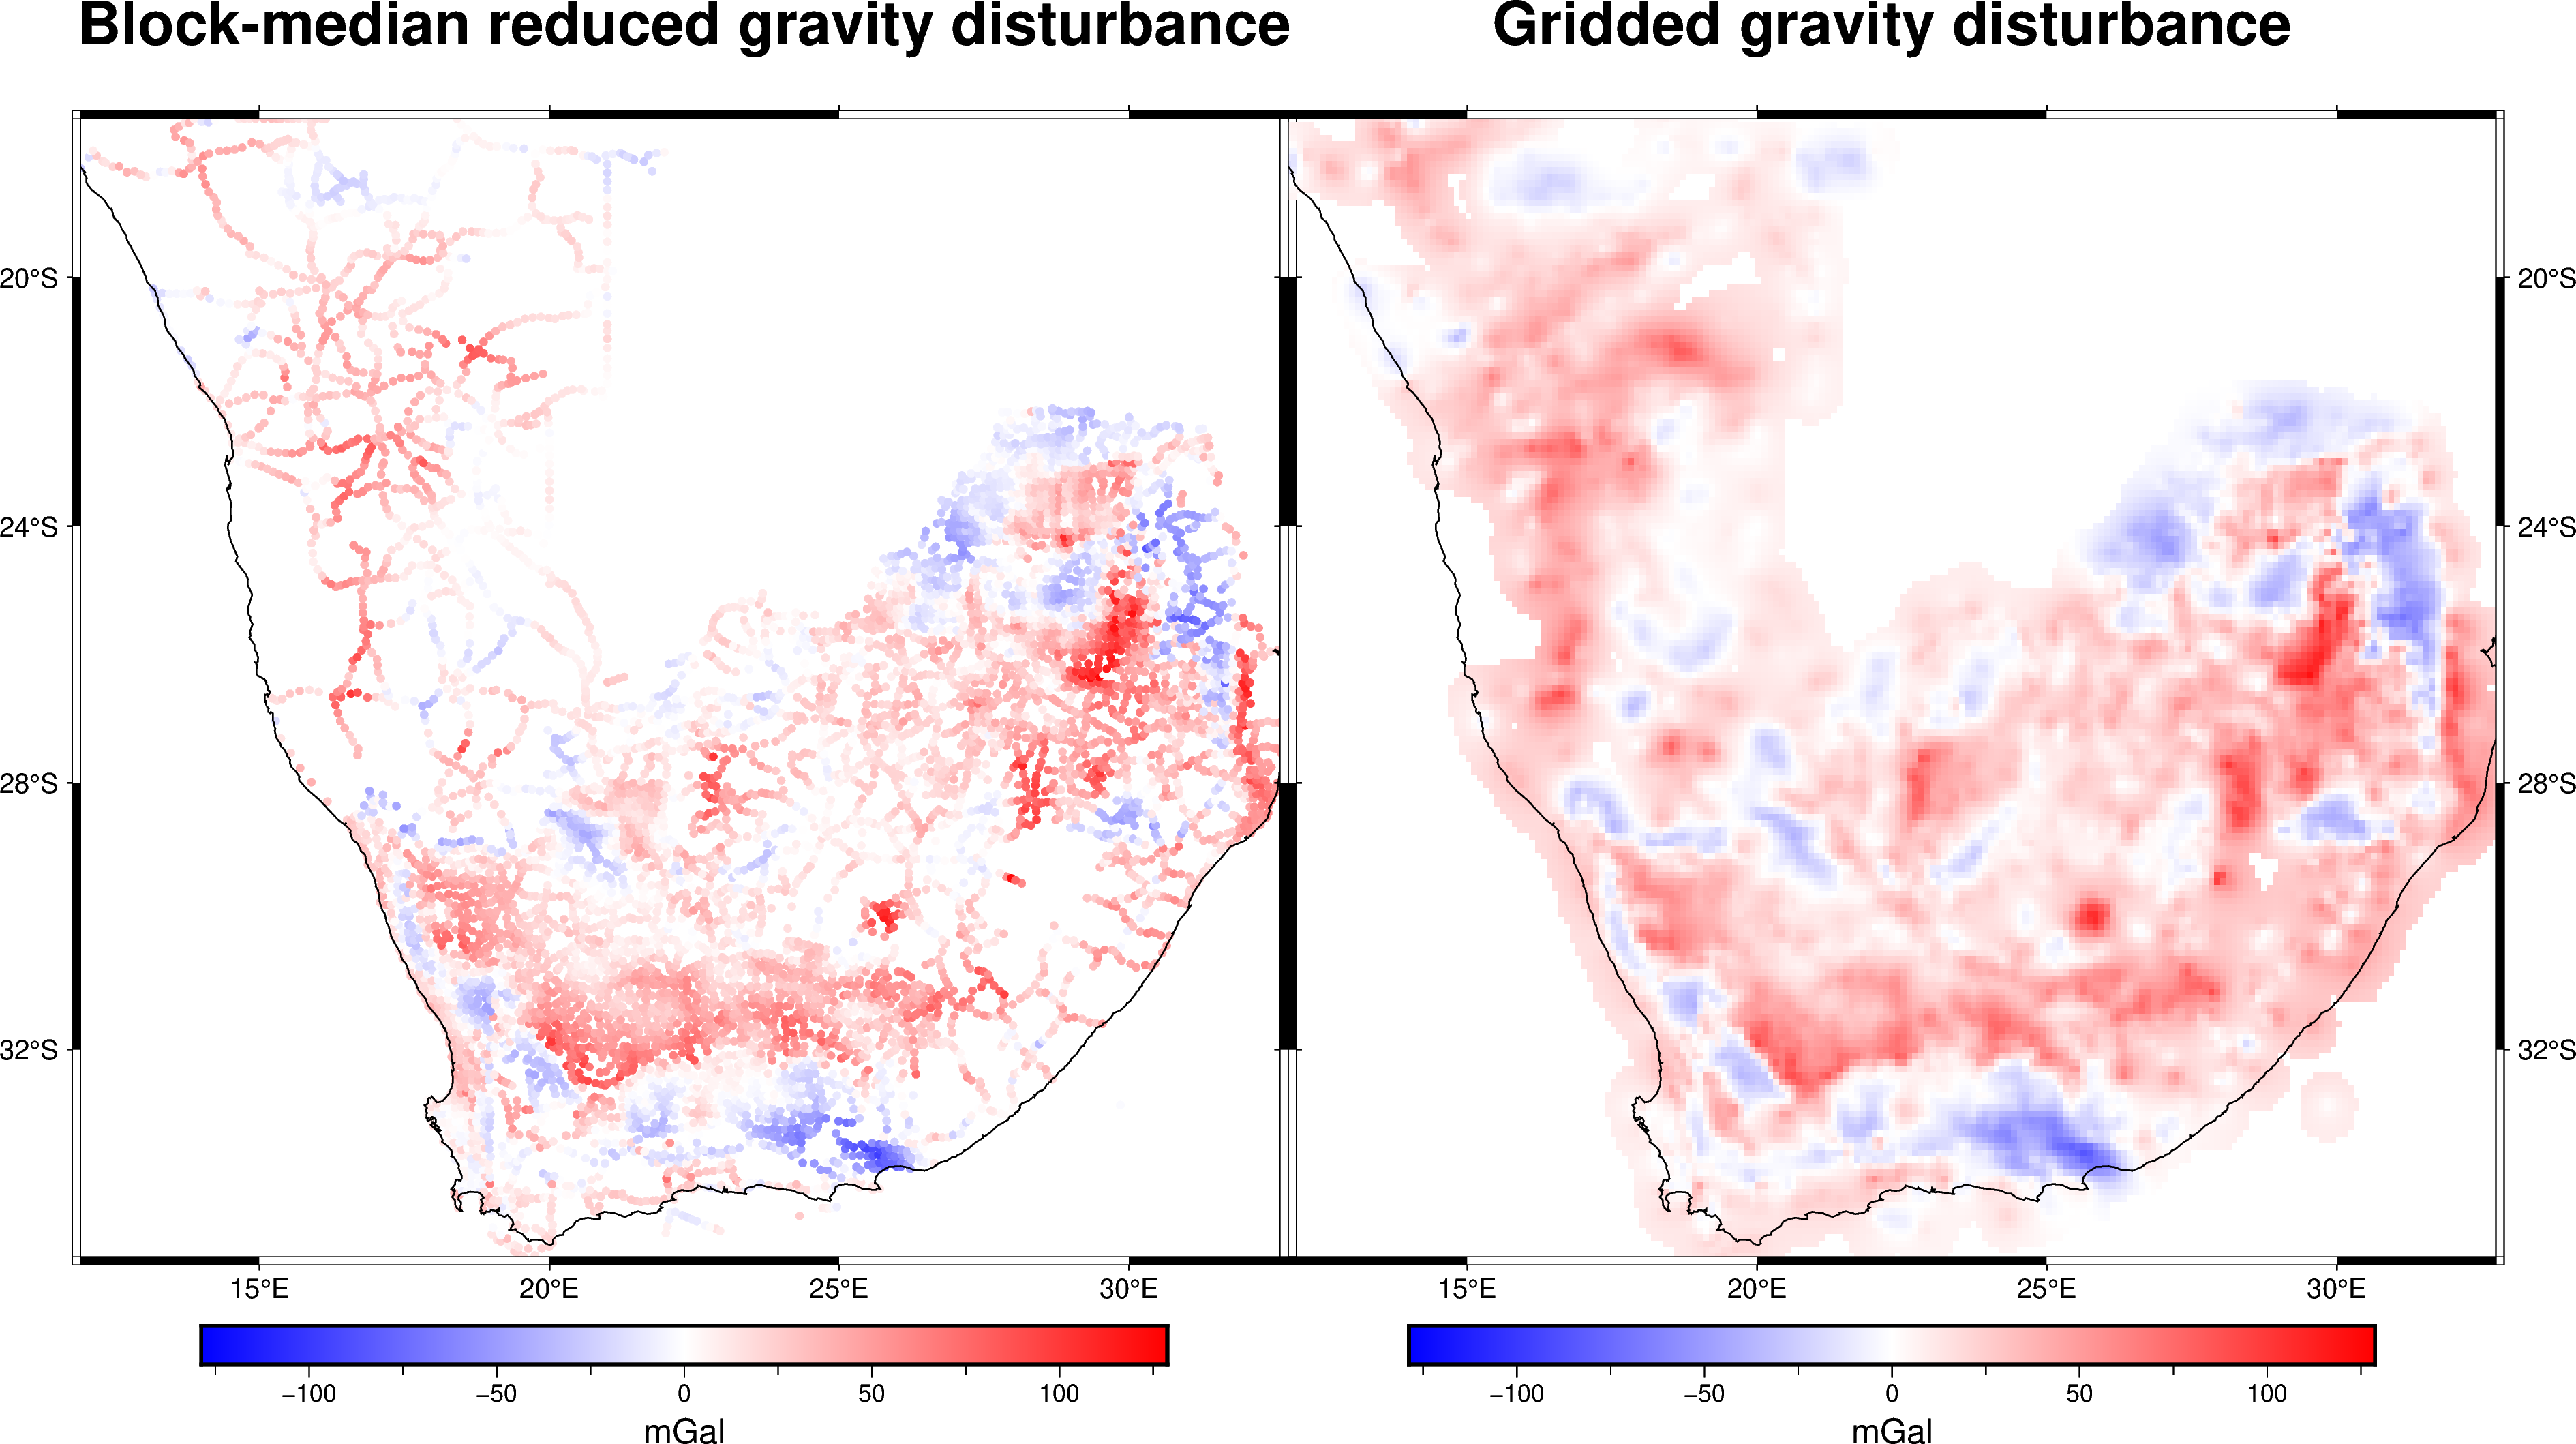

In [13]:
import pygmt

maxabs = vd.maxabs(gravity_disturbance, grid.gravity_disturbance.values)

fig = pygmt.Figure()

# Make colormap of data
pygmt.makecpt(cmap="polar+h0",series=(-maxabs, maxabs,))

title = "Block-median reduced gravity disturbance"
fig.plot(
    projection="M100/15c",
    region=region,
    frame=[f"WSne+t{title}", "xa5", "ya4"],
    x=longitude,
    y=latitude,
    fill=gravity_disturbance,
    style="c0.1c",
    cmap=True,
)
fig.coast(shorelines="0.5p,black", area_thresh=1e4)
fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.shift_origin(xshift='w+3c')

title = "Gridded gravity disturbance"
fig.grdimage(
    grid=grid.gravity_disturbance,
    cmap=True,
    frame=[f"ESnw+t{title}","xa5", "ya4"],
    nan_transparent=True,
)
fig.coast(shorelines="0.5p,black", area_thresh=1e4)
fig.colorbar(cmap=True, frame=["a50f25", "x+lmGal"])

fig.show()